# Song popularity dataset
Predicting the popularity of a song

### Importing library's

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, softmax
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

%matplotlib widget

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

## EDA/Pre-Processing
Exploratory data analysis

In [61]:
df = pd.read_csv("archive/song_data.csv")
df.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [62]:
df.shape

(18835, 15)

### Delete duplicates, based on song name

In [63]:
df.drop_duplicates(subset='song_name', keep='first', inplace=True)
df.shape

(13070, 15)

Look at the composition of the dataset

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13070 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         13070 non-null  object 
 1   song_popularity   13070 non-null  int64  
 2   song_duration_ms  13070 non-null  int64  
 3   acousticness      13070 non-null  float64
 4   danceability      13070 non-null  float64
 5   energy            13070 non-null  float64
 6   instrumentalness  13070 non-null  float64
 7   key               13070 non-null  int64  
 8   liveness          13070 non-null  float64
 9   loudness          13070 non-null  float64
 10  audio_mode        13070 non-null  int64  
 11  speechiness       13070 non-null  float64
 12  tempo             13070 non-null  float64
 13  time_signature    13070 non-null  int64  
 14  audio_valence     13070 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 1.6+ MB


Check for null values

In [65]:
df.isnull().values.any()

False

In [66]:
#sns.pairplot(df)

### Correlation matrix

In [67]:
#plt.figure(figsize=(15,10))
#sns.heatmap(df.corr(),annot= True,)
#plt.show()

array([[<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'loudness'}>]], dtype=object)

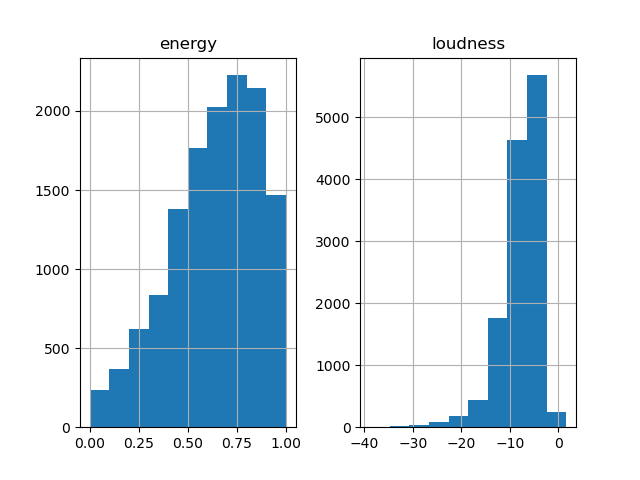

In [68]:
df.hist(column=['energy', 'loudness'])

Loudness and Energy is strong correlated, so we can drop one of them, because they give the same info to the model

In [69]:
df.drop('loudness', axis=1)

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,1,0.0294,167.060,4,0.4740
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,0,0.0498,105.256,4,0.3700
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,1,0.0792,123.881,4,0.3240
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,1,0.1070,122.444,4,0.1980
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,1,0.0313,172.011,4,0.5740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18827,Stay Awake,55,114582,0.898000,0.370,0.136,0.000263,7,0.0999,1,0.0433,146.081,4,0.0592
18830,Let It Breathe,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,1,0.0348,113.969,4,0.3000
18832,Sudden Love (Acoustic),23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,1,0.0355,130.534,4,0.2860
18833,Gentle on My Mind,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,1,0.0328,106.063,4,0.3230


In [70]:
df.shape

(13070, 15)

In [71]:
X, y = df.drop('song_name',axis=1).to_numpy(), df['song_popularity'].to_numpy()

## Making the model

### First model trained with all data

In [72]:
model_regression = Sequential(
    [
        #tf.keras.Input(shape=(14,)),  # specify input shape
        Dense(10, activation='relu', name="L1", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization
        Dense(5, activation='relu', name="L2", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization
        Dense(1, activation='linear', name="Output"),  # Linear activation for regression
    ], name="my_regression_model"
)
model_regression.compile(
    loss='mean_squared_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
     )

In [73]:
# history_regression = model_regression.fit(
#     X, y,
#     epochs=100
# )

## Second model, where dataset is divided in training data and test data

In [74]:
# using the train test split function 
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.4, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X_train.shape (7842, 14) y_train.shape (7842,)
X_test.shape (5228, 14) y_test.shape (5228,)


In [75]:
model_regression_60_40 = Sequential(
    [

        #tf.keras.Input(shape=(14,)),  # specify input shape
        Dense(10, activation='relu', name="L1", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization
        Dense(5, activation='relu', name="L2", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization
        Dense(1, activation='linear', name="Output"),  # Linear activation for regression

    ], name="my_regression_model_60_40"
)

model_regression_60_40.compile(
    loss='mean_squared_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
     )

In [76]:
# early_stop= EarlyStopping(patience=20)

# history_regression_60_40 = model_regression_60_40.fit(
#     X_train, y_train,
#     epochs=200,
#     callbacks=[early_stop]
# )

In [77]:
# plt.plot(pd.DataFrame(model_regression_60_40.history.history))
# plt.ylim(0, 1000)
# plt.show()

In [78]:
# number_of_tests = 200
# sum_difference = 0

# for i in range(number_of_tests):
#     prediction = model_regression_60_40.predict(X_test[i].reshape(1,14))
#     print(f"{prediction} -> {y_test[i]}")
#     sum_difference += np.power(prediction - y_test[i],2)
    
# print(f"MSE: {(sum_difference/number_of_tests)[0][0]}")

## Third model; tuned hyperparameters, 60% training, 40% test

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.4, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X_train.shape (7842, 14) y_train.shape (7842,)
X_test.shape (5228, 14) y_test.shape (5228,)


In [101]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [102]:
model_regression_tuned = Sequential(
    [

        tf.keras.Input(shape=(14,)),  # specify input shape
        Dense(10, activation='relu', name="L1", kernel_regularizer=tf.keras.regularizers.l2(0.3)), # CHANGED: Regularization
        Dense(5, activation='relu', name="L2", kernel_regularizer=tf.keras.regularizers.l2(0.3)), # CHANGED: Regularization
        Dense(2, activation='relu', name="L3", kernel_regularizer=tf.keras.regularizers.l2(0.3)), # CHANGED: Regularization
        Dense(1, activation='linear', name="Output"),  # Linear activation for regression

    ], name="my_regression_model_tuned"
)

model_regression_tuned.compile(
    loss='mean_squared_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), # CHANGED: alpha
     )

In [103]:
#early_stop= EarlyStopping(patience=20)

model_regression_tuned.fit(
    X_train_scaled, y_train,
    epochs=200,
    #callbacks=[early_stop]
)

Epoch 1/200
246/246 [==============================] - 1s 1ms/step - loss: 2689.7520
Epoch 2/200
246/246 [==============================] - 0s 1ms/step - loss: 2451.3364
Epoch 3/200
246/246 [==============================] - 0s 1ms/step - loss: 1870.7723
Epoch 4/200
246/246 [==============================] - 0s 1ms/step - loss: 1043.9908
Epoch 5/200
246/246 [==============================] - 0s 1ms/step - loss: 427.6369
Epoch 6/200
246/246 [==============================] - 0s 2ms/step - loss: 216.7437
Epoch 7/200
246/246 [==============================] - 0s 1ms/step - loss: 153.3697
Epoch 8/200
246/246 [==============================] - 0s 2ms/step - loss: 122.6509
Epoch 9/200
246/246 [==============================] - 0s 1ms/step - loss: 103.9283
Epoch 10/200
246/246 [==============================] - 0s 1ms/step - loss: 91.3534
Epoch 11/200
246/246 [==============================] - 0s 1ms/step - loss: 82.1173
Epoch 12/200
246/246 [==============================] - 0s 1ms/step - lo

In [104]:
number_of_tests = 100
sum_difference = 0

for i in range(number_of_tests):
    prediction = model_regression_tuned.predict(X_test_scaled[i].reshape(1,14))
    print(f"{prediction} -> {y_test[i]}")
    sum_difference += np.power(prediction - y_test[i],2)

print(f"MSE: {(sum_difference/number_of_tests)[0][0]}")

1/1 [==============================] - 0s 56ms/step
[[22.054478]] -> 22
1/1 [==============================] - 0s 30ms/step
[[40.024124]] -> 40
1/1 [==============================] - 0s 19ms/step
[[69.96411]] -> 70
1/1 [==============================] - 0s 21ms/step
[[50.07865]] -> 50
1/1 [==============================] - 0s 21ms/step
[[41.984306]] -> 42
1/1 [==============================] - 0s 20ms/step
[[36.959858]] -> 37
1/1 [==============================] - 0s 20ms/step
[[57.003525]] -> 57
1/1 [==============================] - 0s 18ms/step
[[69.97951]] -> 70
1/1 [==============================] - 0s 17ms/step
[[59.98832]] -> 60
1/1 [==============================] - 0s 19ms/step
[[52.030655]] -> 52
1/1 [==============================] - 0s 30ms/step
[[38.03133]] -> 38
1/1 [==============================] - 0s 19ms/step
[[46.064125]] -> 46
1/1 [==============================] - 0s 18ms/step
[[59.98312]] -> 60
1/1 [==============================] - 0s 19ms/step
[[57.983383]] -> 5